# Interacting With Data

In [1]:
from IPython.display import display, Image, HTML
from talktools import website, nbviewer

## Data exploration

Data exploration is an iterative process that involves repeated passes at visualization, interaction and computation:

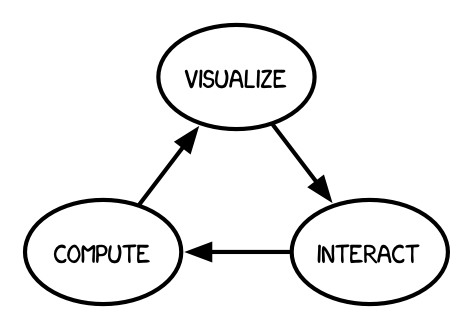

In [2]:
Image('images/VizInteractCompute.png')

## Interactive statistics

Let's explore a 2d normal distribution:

$$
f_{\mathbf x}(x_1,\ldots,x_k) =
\frac{1}{\sqrt{(2\pi)^k|\boldsymbol\Sigma|}}
\exp\left(-\frac{1}{2}({\mathbf x}-{\boldsymbol\mu})^T{\boldsymbol\Sigma}^{-1}({\mathbf x}-{\boldsymbol\mu})
\right)
$$

$$
   \boldsymbol\mu = \begin{pmatrix} \mu_x \\ \mu_y \end{pmatrix}, \quad
    \boldsymbol\Sigma = \begin{pmatrix} \sigma_x^2 & \rho \sigma_x \sigma_y \\
                             \rho \sigma_x \sigma_y  & \sigma_y^2 \end{pmatrix}
$$

In [3]:
from IPython.html.widgets import interact

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [6]:
def normal_2d(n, mux, muy, sigmax, sigmay, corr):
    mean = [mux, muy]
    cov = [[sigmax**2, corr*sigmax*sigmay],[corr*sigmax*sigmay,sigmay**2]]
    d = np.random.multivariate_normal(mean, cov, n)
    return d[:,0], d[:,1]

In [7]:
x, y = normal_2d(100, 0.0, 0.0, 3.0, 2.0, 0.8)

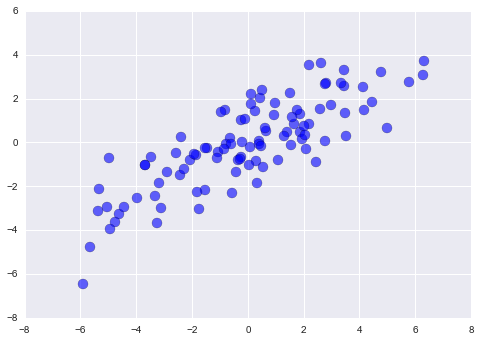

In [8]:
plt.scatter(x, y, s=100, alpha=0.6);

In [9]:
def plot_normal_2d(n, mux, muy, sigmax, sigmay, corr):
    x, y = normal_2d(n, mux, muy, sigmax, sigmay, corr)
    plt.scatter(x, y, s=100, alpha=0.6)
    plt.axis([-10.0,10.0,-10.0,10.0])

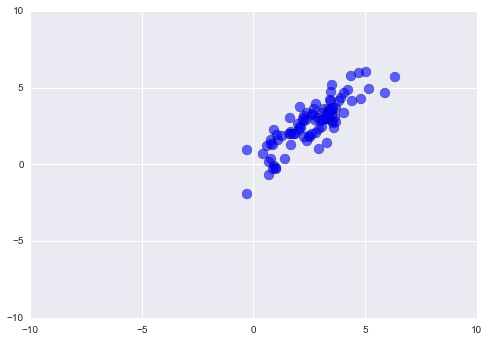

In [10]:
interact(plot_normal_2d, n=(10,100,10), mux=(-5.0,5.0,0.1), muy=(-5.0,5.0,0.1),
         sigmax=(0.01,5.0,0.01), sigmay=(0.01,5.0,0.01), corr=(-0.99,0.99,0.01));